# Insurance Prediction Challenge

## Context

https://zindi.africa/competitions/insurance-prediction-challenge

## 0. Préalable

### Importation des modules

In [137]:
# numerical calculation
import numpy as np
# dataframe
import pandas as pd
# vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
# models
from catboost import CatBoostClassifier
# splitting
from sklearn.model_selection import train_test_split, StratifiedKFold
# encoding
from sklearn.preprocessing import OrdinalEncoder
# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
# metrics
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
# utils
import random
from datetime import datetime as dt
# saving model
import joblib

In [191]:
pd.options.display.max_rows = 10
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

In [49]:
# Set seed for reproducability
SEED = 12
random.seed(SEED)
np.random.seed(SEED)

### Chargement des jeux de données

In [3]:
DATA_PATH = 'data/'
train = pd.read_csv(DATA_PATH + 'train_data.csv')
test = pd.read_csv(DATA_PATH + 'test_data.csv')
sample_submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv')
variable_description = pd.read_csv(DATA_PATH + 'VariableDescription.csv')

In [4]:
train.head(3)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0


In [5]:
test.head(3)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310


Variables identifiant et objectif

In [6]:
ID = 'Customer Id'
TARGET = 'Claim'

## 1. Analyse exploratoire

### 1.1. Analyse de la forme

Dimension du dataset

In [50]:
# Let’s observe the shape of our datasets.
print('Dimension du train set :', train.shape)
print('Dimension du test set :', test.shape)

Dimension du train set : (7160, 14)
Dimension du test set : (3069, 14)


Ratio entre train et test sets

In [9]:
# proportion de l'ensemble de test par rapport à l'ensemble d'apprentissage 
test.shape[0] * 100 / (train.shape[0] + test.shape[0])

30.00293283800958

Description du type des variables

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         3069 non-null   object 
 1   YearOfObservation   3069 non-null   int64  
 2   Insured_Period      3069 non-null   float64
 3   Residential         3069 non-null   int64  
 4   Building_Painted    3069 non-null   object 
 5   Building_Fenced     3069 non-null   object 
 6   Garden              3065 non-null   object 
 7   Settlement          3069 non-null   object 
 8   Building Dimension  3056 non-null   float64
 9   Building_Type       3069 non-null   int64  
 10  Date_of_Occupancy   2341 non-null   float64
 11  NumberOfWindows     3069 non-null   object 
 12  Geo_Code            3056 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 311.8+ KB


Description des colonnes

In [192]:
def afficher_value_counts(df: pd.DataFrame) -> None:
    for colonne in list(df.columns):
        print(colonne)
        print(df[colonne].value_counts(), '\n')

afficher_value_counts(train)

Customer Id
Customer Id
H14663    1
H19182    1
H1571     1
H15027    1
H15026    1
         ..
H5025     1
H19098    1
H16571    1
H16570    1
H7470     1
Name: count, Length: 7160, dtype: int64 

YearOfObservation
YearOfObservation
2012    1858
2013    1811
2014    1373
2015    1075
2016    1043
Name: count, dtype: int64 

Insured_Period
Insured_Period
1.000000    5325
0.997268     547
0.000000     165
0.747945      60
0.495890      49
            ... 
0.435616       1
0.308743       1
0.437158       1
0.578082       1
0.030137       1
Name: count, Length: 401, dtype: int64 

Residential
Residential
0.0    4973
1.0    2187
Name: count, dtype: int64 

Building_Painted
Building_Painted
1.0    5382
0.0    1778
Name: count, dtype: int64 

Building_Fenced
Building_Fenced
0.0    3608
1.0    3552
Name: count, dtype: int64 

Garden
Garden
0.0    3602
1.0    3551
Name: count, dtype: int64 

Settlement
Settlement
0.0    3610
1.0    3550
Name: count, dtype: int64 

Building Dimension
Building D

In [55]:
afficher_value_counts(test)

Customer Id
Customer Id
H11920    1
H1186     1
H9420     1
H9411     1
H9421     1
H9422     1
H11798    1
H10217    1
H10674    1
H9867     1
H1185     1
H1199     1
H7488     1
H1200     1
H1201     1
H12238    1
H973      1
H975      1
H976      1
H977      1
H9257     1
H9258     1
H7489     1
H7487     1
H9951     1
H10823    1
H7759     1
H8656     1
H8660     1
H8449     1
H10147    1
H9409     1
H95       1
H8807     1
H8808     1
H12450    1
H10554    1
H11570    1
H92       1
H11219    1
H11220    1
H11221    1
H11404    1
H8805     1
H8452     1
H10553    1
H10779    1
H9952     1
H11564    1
H7907     1
H11995    1
H9478     1
H9479     1
H9787     1
H11955    1
H754      1
H11656    1
H12074    1
H12591    1
H9408     1
H1063     1
H10889    1
H1012     1
H1021     1
H1023     1
H1025     1
H1034     1
H1035     1
H1037     1
H10151    1
H1064     1
H9541     1
H9953     1
H8951     1
H10950    1
H8626     1
H10629    1
H11474    1
H7745     1
H869      1
H870      1
H873

Analyse des variables qualitatives

In [11]:
train.describe(include='object')

,Customer Id,Building_Painted,Building_Fenced,Garden,Settlement,NumberOfWindows,Geo_Code
count,7160,7160,7160,7153,7160,7160,7058
unique,7160,2,2,2,2,11,1307
top,H14663,V,N,O,R,.,6088
freq,1,5382,3608,3602,3610,3551,143


- La colonne `NumberOfWindows` contient des chiffres de 1 à 9 et deux valeurs spéciales : un point (.) et une description mathématique (>=10). Ce qui a fait de cette colonne une variable _object_. Pour un apprentissage correct, nous transformerons ces deux valeurs spéciales en chiffres, soit 0 et 10 respectivement. <br>
- La colonne `Geo_Code` a l'air de ne contenir que des nombres mais il s'avère qu'elle est de type _object_.

Analyse des variables quantitatives

In [12]:
train.describe(include='number').round(2)

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.00,7160.00,7160.00,7054.00,7160.00,6652.00,7160.00
mean,2013.67,0.91,0.31,1883.73,2.19,1964.46,0.23
std,1.38,0.24,0.46,2278.16,0.94,36.00,0.42
min,2012.00,0.00,0.00,1.00,1.00,1545.00,0.00
25%,2012.00,1.00,0.00,528.00,2.00,1960.00,0.00
50%,2013.00,1.00,0.00,1083.00,2.00,1970.00,0.00
75%,2015.00,1.00,1.00,2289.75,3.00,1980.00,0.00
max,2016.00,1.00,1.00,20940.00,4.00,2016.00,1.00


Analyse des données manquantes

In [13]:
train.isnull().sum() / train.shape[0] * 100

Customer Id           0.000000
YearOfObservation     0.000000
Insured_Period        0.000000
Residential           0.000000
Building_Painted      0.000000
Building_Fenced       0.000000
Garden                0.097765
Settlement            0.000000
Building Dimension    1.480447
Building_Type         0.000000
Date_of_Occupancy     7.094972
NumberOfWindows       0.000000
Geo_Code              1.424581
Claim                 0.000000
dtype: float64

### 1.2. Analyse du fond

Analyse et visualisation de la target

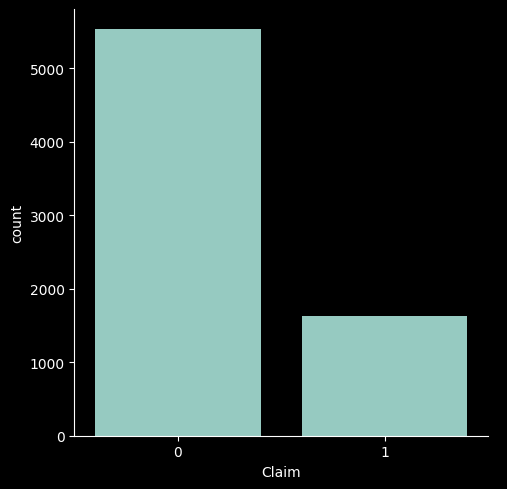

In [65]:
# explorons la distribution de la target
sns.catplot(data=train, x=TARGET, kind='count')
plt.show()

Visualisation d'autres variables

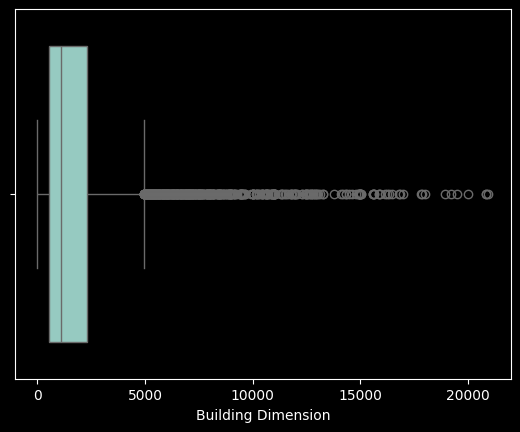

In [15]:
# Checking distribution to help decide the imputation method to use for the continous variables
sns.boxplot(x=train['Building Dimension'])
plt.show()

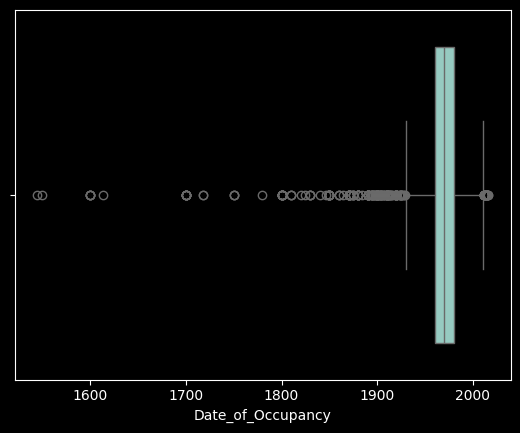

In [16]:
sns.boxplot(x=train['Date_of_Occupancy'])
plt.show()

In [18]:
# Separating the dataset as per the two types of claims
train_0 = train[train['Claim'] == 0]
train_1 = train[train['Claim'] == 1]

Compréhension des variables

In [19]:
variable_description

,Variable,Description
0,Customer Id,Identification number for the Policy holder
1,YearOfObservation,year of observation for the insured policy
2,Insured_Period,duration of insurance policy in Olusola Insura...
3,Residential,is the building a residential building or not
4,Building_Painted,"is the building painted or not (N-Painted, V-N..."
5,Building_Fenced,"is the building fence or not (N-Fenced, V-Not ..."
6,Garden,building has garden or not (V-has garden; O-no...
7,Settlement,Area where the building is located. (R- rural ...
8,Building Dimension,Size of the insured building in m2
9,Building_Type,"The type of building (Type 1, 2, 3, 4)"


Matrice de corrélation entre les variables

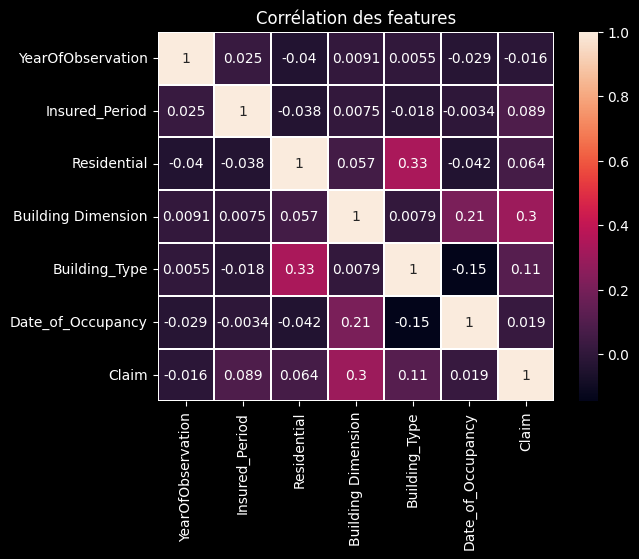

In [21]:
plt.title('Matrice de corrélation')
sns.heatmap(train.corr(numeric_only=True), linewidths=0.05, annot=True)
plt.show()

> 00 corrélation entre les variables du dataset

## 2. Preprocessing

### Deleting missing values 

In [66]:
train1 = train.copy()
test1 = test.copy()

In [69]:
train1.isnull().sum().sort_values()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Settlement              0
Building_Type           0
NumberOfWindows         0
Claim                   0
Garden                  7
Geo_Code              102
Building Dimension    106
Date_of_Occupancy     508
dtype: int64

In [70]:
test1.isnull().sum().sort_values()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Settlement              0
Building_Type           0
NumberOfWindows         0
Claim                   0
Garden                  4
Building Dimension     13
Geo_Code               13
Date_of_Occupancy     728
dtype: int64

### Dummification

In [206]:
def preprocess_data1(df1: pd.DataFrame, ordinal_encoder=None, scaler=None):
    # copie du dataset
    df = df1.copy()
    # suppression de la variable d'identifiants uniques
    df.drop(ID, axis=1, inplace=True)
    # Encoder les colonnes catégoriques
    categorical_cols = list(df.select_dtypes(include='object').columns)
    if ordinal_encoder is None:
        ordinal_encoder = OrdinalEncoder()
        df[categorical_cols] = ordinal_encoder.fit_transform(
            df[categorical_cols])
    else:
        df[categorical_cols] = ordinal_encoder.transform(df[categorical_cols])

    # Normaliser les colonnes numériques
    numeric_cols = df.select_dtypes(
        include='number').columns.difference([TARGET])
    if scaler is None:
        scaler = StandardScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    else:
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df


def preprocess_data(df1: pd.DataFrame, ordinal_encoder=None, scaler=None, id_col='Customer Id', target_col='Claim'):
    # Copie des données
    df = df1.copy()

    # Suppression de la colonne des identifiants
    if id_col in df.columns:
        df.drop(columns=[id_col], inplace=True)

    # Traitement spécifique des colonnes
    if 'NumberOfWindows' in df.columns:
        df['NumberOfWindows'] = (
            df['NumberOfWindows']
            .str.strip()  # Supprime les espaces
            .replace({'.': 0, '>=10': 10})  # Remplace les valeurs spécifiques
            .astype(float)  # Convertit en float
        )

    if 'Date_of_Occupancy' in df.columns:
        current_year = 2024
        df['Building_Age'] = current_year - df['Date_of_Occupancy']

    # Identification des colonnes catégoriques
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # Encoder les colonnes catégoriques
    if ordinal_encoder is None:
        ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        df[categorical_cols] = ordinal_encoder.fit_transform(df[categorical_cols])
    else:
        df[categorical_cols] = ordinal_encoder.transform(df[categorical_cols])

    # Identification des colonnes numériques
    numeric_cols = df.select_dtypes(include='number').columns.difference([target_col])

    # Normalisation des colonnes numériques
    if scaler is None:
        scaler = StandardScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    else:
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # Ajout éventuel de la colonne cible
    if target_col not in df.columns:
        df[target_col] = 0  # Valeur par défaut

    return df

Instantiating the scalers

In [26]:
# Instantiating the scalers
MMS = MinMaxScaler()
MAS = MaxAbsScaler()
SS = StandardScaler()
RS = RobustScaler()

In [207]:
scaler = MAS
train_pp = preprocess_data(train, None, scaler)
test_pp = preprocess_data(test, None, scaler)

train_pp.head(3)

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim,Building_Age
0,0.998512,1.0,0.0,0.0,1.0,1.0,1.0,0.013849,0.0,0.972222,0.0,0.00536,0,0.133612
1,0.999504,1.0,0.0,1.0,0.0,0.0,0.0,0.023400,0.0,0.917659,0.4,0.00536,0,0.363257
2,0.999008,1.0,0.0,0.0,1.0,1.0,1.0,0.028415,0.0,0.972222,0.0,0.00536,0,0.133612


In [208]:
test_pp.head(3)

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim,Building_Age
0,0.998512,1.000000,0.0,1.0,0.0,0.0,0.0,0.009758,0.25,0.974155,0.3,0.204023,0,0.233577
1,1.000000,0.997268,0.0,1.0,0.0,0.0,0.0,0.009758,0.25,0.974155,0.3,0.204023,0,0.233577
2,0.998512,0.369863,0.0,1.0,1.0,1.0,1.0,0.025695,0.25,0.974155,0.0,0.204023,0,0.233577


## Modelling

In [100]:
def calcul_auc(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    return auc(fpr, tpr)

### Entrainement du modèle avec CatBoost

In [228]:
X = train_pp.drop([TARGET], axis=1)
y = train_pp[TARGET]

X_Train, X_Val, y_Train, y_Val = train_test_split(X, y, test_size = 0.31, random_state=SEED)

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
# for train_idx, val_idx in skf.split(X, y):
#     X_Train, X_Val = X.iloc[train_idx], X.iloc[val_idx]
#     y_Train, y_Val = y.iloc[train_idx], y.iloc[val_idx]

params = {
    'n_estimators': 5000,
    'learning_rate': 0.01,
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'rsm': 0.8,
    'depth': 6,
    'l2_leaf_reg': 5,
    'bagging_temperature': 1.0,
    'random_seed': 444,
    'early_stopping_rounds': 200,
    'use_best_model': True,
    'class_weights': [1, 5],  # Exemples de poids pour classes déséquilibrées
}


model_cb = CatBoostClassifier(**params)
model_cb.fit(X_Train, y_Train, eval_set=[(X_Val, y_Val)], verbose=50)

y_model_cb = model_cb.predict(X_Val)

metrique = calcul_auc(y_Val, y_model_cb)

print(f"Taux d'erreur du {str(model_cb)} : {metrique}")

0:	test: 0.7139631	best: 0.7139631 (0)	total: 5.33ms	remaining: 26.7s
50:	test: 0.7406202	best: 0.7409530 (42)	total: 246ms	remaining: 23.9s
100:	test: 0.7422627	best: 0.7427895 (78)	total: 480ms	remaining: 23.3s
150:	test: 0.7429490	best: 0.7431344 (140)	total: 814ms	remaining: 26.2s
200:	test: 0.7445379	best: 0.7445472 (199)	total: 1.08s	remaining: 25.9s
250:	test: 0.7448816	best: 0.7448816 (250)	total: 1.32s	remaining: 25s
300:	test: 0.7441044	best: 0.7448816 (250)	total: 1.56s	remaining: 24.3s
350:	test: 0.7440722	best: 0.7448816 (250)	total: 1.8s	remaining: 23.8s
400:	test: 0.7440964	best: 0.7448816 (250)	total: 2.02s	remaining: 23.2s
450:	test: 0.7435126	best: 0.7448816 (250)	total: 2.25s	remaining: 22.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7448816395
bestIteration = 250

Shrink model to first 251 iterations.
Taux d'erreur du <catboost.core.CatBoostClassifier object at 0x0000025D1E2FF0E0> : 0.6844336901591381


0.6580983568050791

0.6575853981215695

In [229]:
feature_importances = model_cb.get_feature_importance(prettified=True)
print(feature_importances)

            Feature Id  Importances
0   Building Dimension    35.356826
1       Insured_Period    13.992893
2        Building_Type    10.361355
3    Date_of_Occupancy     6.497117
4             Geo_Code     6.324080
..                 ...          ...
8          Residential     4.092984
9               Garden     1.865127
10     Building_Fenced     1.645745
11    Building_Painted     1.481487
12          Settlement     1.070691

[13 rows x 2 columns]


Matrice de confusion

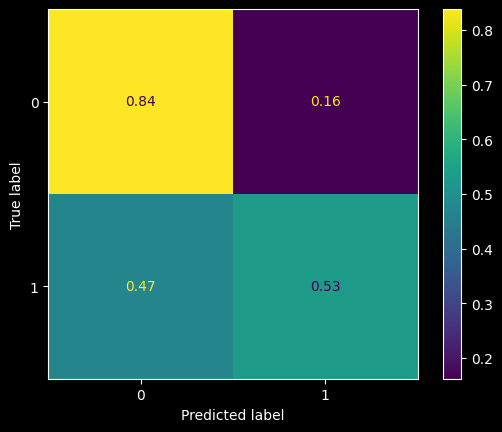

In [230]:
# traçons la matrice de confusion pour le modèle
ConfusionMatrixDisplay.from_estimator(model_cb, X_Val, y_Val, normalize='true')
plt.show()

## Prediction

In [231]:
try:
	test_pp.drop([TARGET], axis=1, inplace=True)
except: pass

test[TARGET] = model_cb.predict(test_pp)
test.head(5)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310,0
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310,0
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310,0
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321,0
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321,0


## Submission

Visualisation du fichier d'exemple de soumission

In [44]:
sample_submission.head()

,Customer Id,Claim
0,H0,1
1,H10000,1
2,H10001,1
3,H10002,1
4,H10003,1


Création de notre fichier de soumission

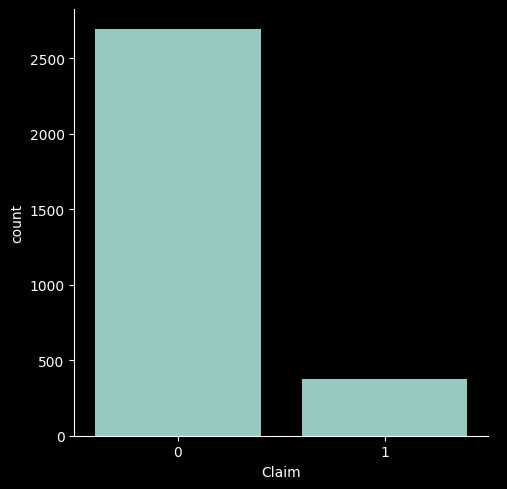

In [232]:
submissions = pd.DataFrame({ID: test[ID], TARGET: test[TARGET].astype(int)})
today = dt.now().strftime(format="%Y-%m-%d_%Hh%M")
submissions.to_csv(f'submissions/submission_{today}.csv', index=False)

# explorons la distribution de la target
sns.catplot(data=submissions, x=TARGET, kind='count')
plt.show()

## Model saving

In [129]:
# Save the model as a pickle in a file
file_name = 'catboost_gpt'
joblib.dump(model_cb, f'models/{file_name}.pkl')

['models/catboost_gpt.pkl']